**Название проекта**

Прогнозирование оттока клиентов
_____
**Описание исследования.**

Нам необходимо проанализировать информацию о клиетах с целью написания модели машинного обучения, определяющей останется ли клиент у нас или уйдет. Для этого нам необходимо провести предобработку данных, где определимся что делать с пропусками, пиковыми значениями, поменяем формат столбцов и подготовим данные перед загрузкой в модель. Выполним исследовательский анализ данных, посмотреть что из себя представляют наши данные, визуализируем их и попробуем найти возможные закономерности. Потом приступим к обучению несколько моделей для определения наиболее подходящей. По скольку у нас задача классификации, то однозначно попробуем дерево решений, случайный лес и градиентный бустинг. После выбора наилучшей модели проверим ее на тестовой выборке, а так же подведем итог нашего исследования.
_____
**Цель исследования.**
    
Создание модели машинного обучения прогнозирующей отток клиентов с метрикой качества AUC-ROC большей 0.85.
   
_____
**Исходные данные.**
    
В нашем распоряжении 4 датасета с информацией о клиентах, их договорах и услугах.
______

**Данное исследование разделим на несколько частей.**

* Предобработка данных
* Исследовательский анализ данных
* Обучение моделей
* Проверка модели на тестовых данных
* Вывод




# Предобработка данных

Загрузим необходимые библиотеки и датасеты.

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    contact = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contact = pd.read_csv('/content/drive/MyDrive/Диплом/contract_new.csv')
    internet = pd.read_csv('/content/drive/MyDrive/Диплом/internet_new.csv')
    personal = pd.read_csv('/content/drive/MyDrive/Диплом/personal_new.csv')
    phone = pd.read_csv('/content/drive/MyDrive/Диплом/phone_new.csv')

Создадим функцию для вывода первых 5 строк, типов данных, основыных показателей, количества пропусков и количества дубликатов.

In [ ]:
def about_data(df):
    print('Первые 5 строк датасета')
    display(df.head())
    print()
    print()
    print('Типы данных')
    print(df.info())
    print()
    print()
    print('Уникальные значения в графах')
    for i in df.columns:
        print('Графа', i)
        print(df[i].sort_values().unique())
        print()
    print()
    print()
    print('Основные показатели')
    print(df.describe())
    print()
    print()
    print('Количество пропусков')
    print(df.isna().sum())
    print()
    print()
    print('Количество дубликатов:',df.duplicated().sum())

In [ ]:
about_data(contact)

Первые 5 строк датасета


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


Уникальные значения в графах
Графа customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

Графа BeginDate
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2

In [ ]:
about_data(internet)

Первые 5 строк датасета


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


Уникальные значения в графах
Графа customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

Графа InternetService
['DSL' 'Fiber optic']

Графа OnlineSecurity
['No' 'Yes']

Графа OnlineBackup
['No' 'Yes']

Графа DeviceProtection
['No' 'Yes']

Графа TechSupport
['No' 'Yes']

Графа StreamingTV
['No' 'Yes']

Графа StreamingMovies
['N

In [ ]:
about_data(personal)

Первые 5 строк датасета


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


Уникальные значения в графах
Графа customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

Графа gender
['Female' 'Male']

Графа SeniorCitizen
[0 1]

Графа Partner
['No' 'Yes']

Графа Dependents
['No' 'Yes']



Основные показатели
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


Количество пропусков
customerID       0
gender           

In [ ]:
about_data(phone)

Первые 5 строк датасета


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


Уникальные значения в графах
Графа customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-RRAMN' '9992-UJOEL'
 '9993-LHIEB']

Графа MultipleLines
['No' 'Yes']



Основные показатели
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390


Количество пропусков
customerID       0
MultipleLines    0
dtype: int64


Количество дубликатов: 0


Мы предварительно посмотрели данные, ключевой для нас будет таблица contact с датой начала и окончания договора, явных пропусков и дубликатов у нас нет. Большинство данных имеют тип object.

Теперь объединим наши таблицы и сразу добавим целевой признак. После посмотрим что получилось.

In [ ]:
data = (contact
      .merge(internet, how="left", on="customerID")
      .merge(personal, how="left", on="customerID")
      .merge(phone, how="left", on="customerID"))

В целевом признаке поставим 0 если нет даты окончания договора и 1 если есть

In [ ]:
data['target'] = data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,No,Female,0,Yes,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,NaN,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,0


Теперь у нас 21 колонка, довольно широкая таблица получилась. Сразу обработаем колонки с датой. Как мы помним датасет у нас до 2020-02-01. В EndDate заменим No на последнюю дату и добавим количество дней пользования услугами нашей компании.

In [ ]:
data['EndDate'] = data['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

data['duration'] = (data['EndDate'] - data['BeginDate']).astype('timedelta64[D]')
data['duration'] = data['duration'].astype('int')

data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,Female,0,Yes,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,...,Yes,No,No,Male,0,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,...,No,No,No,Female,0,No,No,No,0,153


После этой небольшой обработки применим созданную нами функцию about_data, что бы вывести все данные о датасете.

In [ ]:
about_data(data)

Первые 5 строк датасета


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,Female,0,Yes,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,...,Yes,No,No,Male,0,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,...,No,No,No,Female,0,No,No,No,0,153




Типы данных
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingM

В столбце TotalCharges явно должны быть значения float, а так же мы видели что там есть значения ' '. Посмотрим что именно в этих колонках.

In [ ]:
data.loc[data['TotalCharges'] == ' '].head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,...,Yes,Yes,No,Female,0,Yes,Yes,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,NaN,NaN,...,NaN,NaN,NaN,Male,0,No,Yes,No,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,DSL,Yes,...,No,Yes,Yes,Female,0,Yes,Yes,No,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,NaN,NaN,...,NaN,NaN,NaN,Male,0,Yes,Yes,Yes,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,DSL,Yes,...,Yes,Yes,No,Female,0,Yes,Yes,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,NaN,NaN,...,NaN,NaN,NaN,Male,0,Yes,Yes,No,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,NaN,NaN,...,NaN,NaN,NaN,Male,0,Yes,Yes,Yes,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,NaN,NaN,...,NaN,NaN,NaN,Female,0,Yes,Yes,No,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,NaN,NaN,...,NaN,NaN,NaN,Male,0,Yes,Yes,No,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,DSL,No,...,Yes,Yes,No,Female,0,Yes,Yes,Yes,0,0


Как мы видим это договора заключенные 2020-02-01. Хотя я выбрал первые 20 строк, такая выборка включает всего 11 строк. Удалим их.

In [ ]:
data = data.loc[data['TotalCharges'] != ' ']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   object        
 8   InternetService   5512 non-null   object        
 9   OnlineSecurity    5512 non-null   object        
 10  OnlineBackup      5512 non-null   object        
 11  DeviceProtection  5512 non-null   object        
 12  TechSupport       5512 non-null   object        
 13  StreamingTV       5512 non-null   object        
 14  StreamingMovies   5512 n

Теперь изменим типо данных графы TotalCharges.

In [ ]:
data['TotalCharges'] = data['TotalCharges'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   5512 non-null   object        
 9   OnlineSecurity    5512 non-null   object        
 10  OnlineBackup      5512 non-null   object        
 11  DeviceProtection  5512 non-null   object        
 12  TechSupport       5512 non-null   object        
 13  StreamingTV       5512 non-null   object        
 14  StreamingMovies   5512 n

<ipython-input-16-2aa785769c49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalCharges'] = data['TotalCharges'].astype('float')


Теперь займемся пропусками. Они у нас в столбцах с услугами, явно эти пропуски означают что клиент не пользовался нашими услугами, заменим их на No

In [ ]:
culumns_for_replase = ['InternetService',
                       'OnlineSecurity',
                       'OnlineBackup',
                       'DeviceProtection',
                       'TechSupport',
                       'StreamingTV',
                       'StreamingMovies',
                       'MultipleLines']
for i in culumns_for_replase:
    data[i] = data[i].fillna('No')

print('Количество пропусков:', data.isna().sum())

Количество пропусков: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
target              0
duration            0
dtype: int64


На этом закончим предобработку данных. В этом блоке мы посмотрели четыре датасета по отдельности, потом объединили их в один. Заменили типы данных на подходящие. Обработали явные и неявные пропуски. Добавили целевую метрику. Теперь можем приступить к исследовательскому анализу данных.

# Исследовательский анализ данных

Визуализируем наши данные

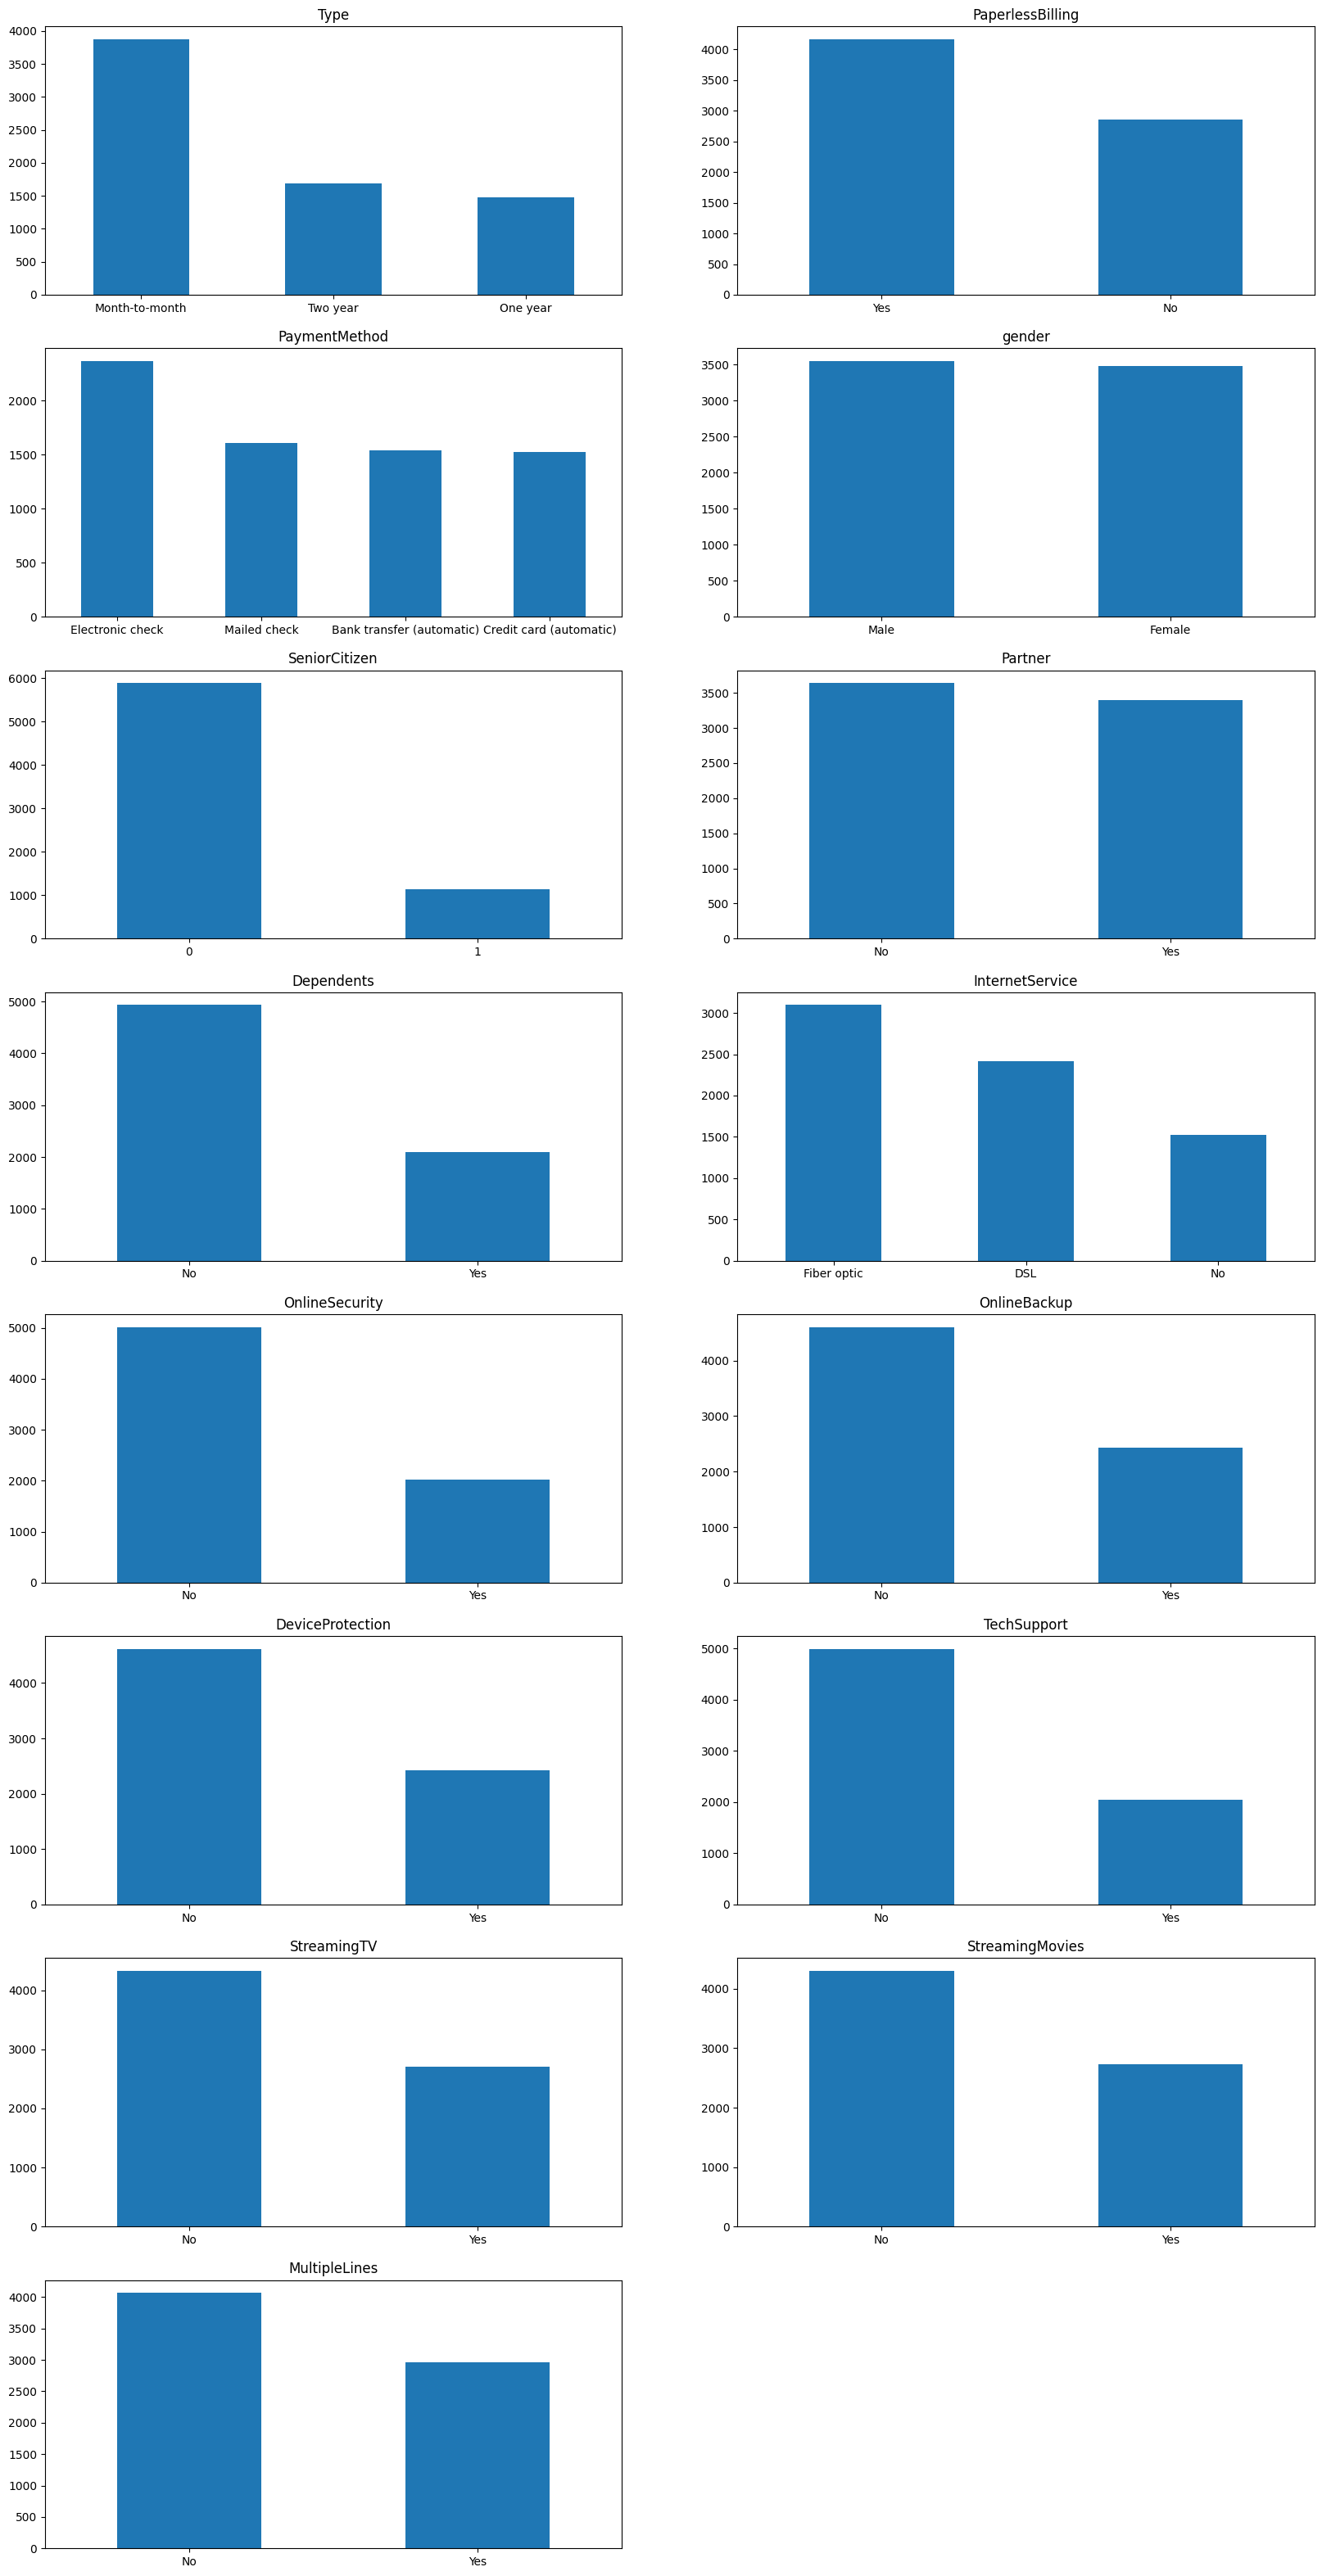

In [ ]:
categorial_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines']

cols = 2
idx = 0
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 40))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)

    data[column].value_counts().plot(
        kind='bar',
        title=column,
        ax=ax,
        rot=0
    )

plt.show()

Как мы видим, помесячный способ оплаты самый популярный. Преобладает безналичный расчет, а счета предпочитают получать в виде электронного чека.
Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines не пользуются популярностью у клиентов.

После небольшого анализа датасета, посмотрим коррелируют ли какие то столбцы. Необходимо будет удалить такие, чтобы повысить качество обучения модели.

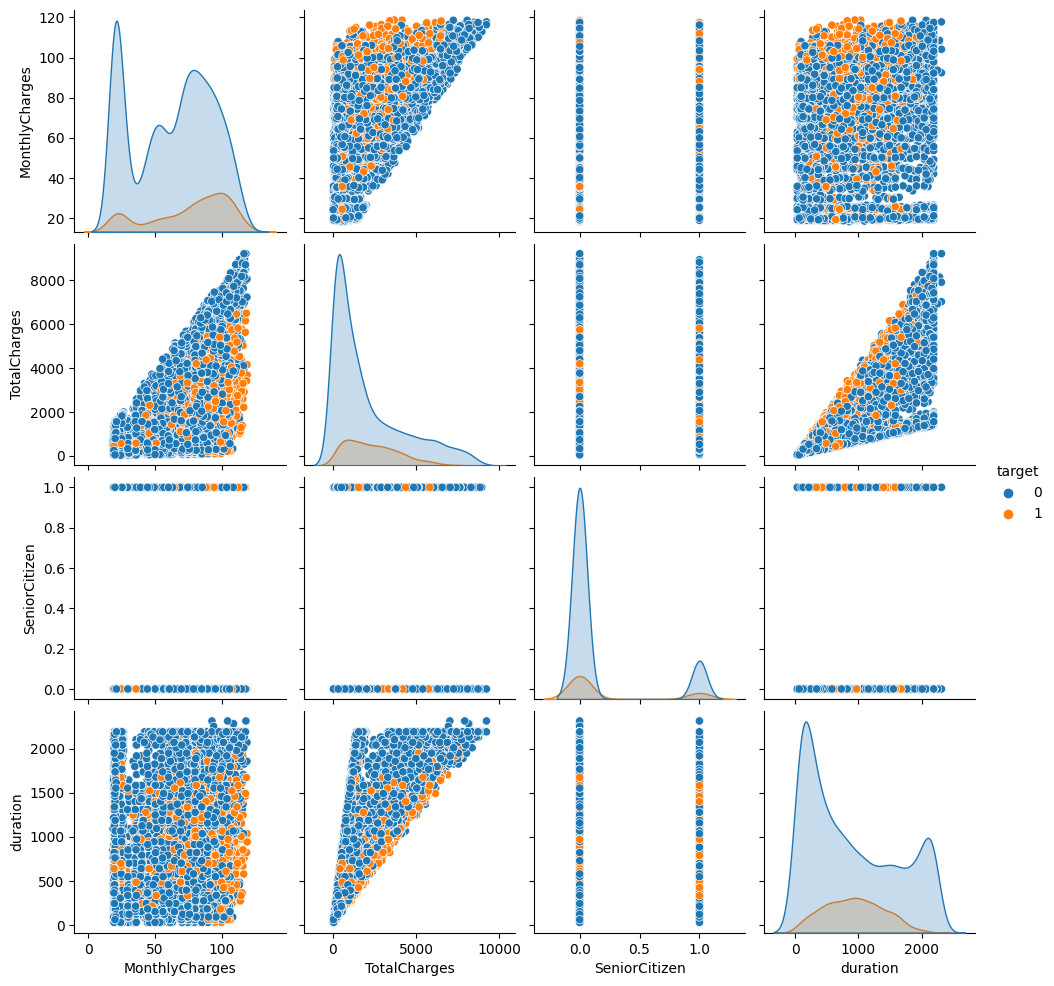

In [ ]:
sns.pairplot(data, hue='target');

In [ ]:
data.corr().drop('SeniorCitizen', axis=1).drop('SeniorCitizen')

<ipython-input-20-b7e6cc90c99f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().drop('SeniorCitizen', axis=1).drop('SeniorCitizen')


,MonthlyCharges,TotalCharges,target,duration
MonthlyCharges,1.000000,0.630297,0.153927,0.218955
TotalCharges,0.630297,1.000000,0.051548,0.821442
target,0.153927,0.051548,1.000000,0.015716
duration,0.218955,0.821442,0.015716,1.000000


Сильно коррелируют графы MonthlyCharges и TotalCharges. Один из них необходимо удалить. По идее важнее сколько человек платит в месяц, чем сколько он принес за все время.

In [ ]:
data = data.drop(labels = ['TotalCharges'], axis = 1)

Теперь рассмотрим распределение классов.

In [ ]:
data['target'].value_counts()

0    5931
1    1101
Name: target, dtype: int64

У нас есть дисбаланс классов, но нам это не должно помешать.

Мы провели исследовательский анализ нашего датасета. Расмотрели предпочтения клиентов. Убрали коррелирующие признаки. Обнаружили, что у нас есть дисбаланс. Теперь можем переходить к обучению моделей.

# Обучение моделей

Для начала выделим целевой признак, удалим лишние колонки, разделим выборки на обучающую и тестовую. И так же сразу введем переменную random_state=80523

In [ ]:
rs = 80523

In [ ]:
target = data['target']
features = data.drop(['customerID', 'target', 'BeginDate', 'EndDate'], axis=1)

В тестовую выборку отнесем 25% выборки.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=rs)

Закодируем наши признаки

In [ ]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

print(features_train_ohe.shape)
print(features_test_ohe.shape)

(5274, 21)
(1758, 21)


Теперь приступим к самому интересному: машинному обучению. Начнем с простой модели, а именно со случайного леса, потом LGBMClassifier и CatBoostClassifier.

В лесу будем менять количество деревьев

In [ ]:
forest_best_roc_auc = 0
for est in range(21,122,20):
    model_tree = RandomForestClassifier(
        n_estimators=est,
        random_state=rs).fit(
            features_train_ohe,
            target_train)
    scores_roc_auc = cross_val_score(model_tree,
                                          features_train_ohe,
                                          target_train,
                                          scoring = 'roc_auc',
                                          cv = 5)
    mean_roc_auc = np.mean(scores_roc_auc)

    if mean_roc_auc > forest_best_roc_auc:
        forest_best_roc_auc = mean_roc_auc
        best_model_tree = model_tree
        best_est = est
print()
print(f"Лучшая модель при количестве деревьев {est}, с оценкой {forest_best_roc_auc}")


Лучшая модель при количестве деревьев 121, с оценкой 0.7940149576832807


Лучшая модель оказалась при максимальном количестве деревьев и получилось добиться результат 0,79401, посмотрим что покажут остальные модели. Теперь у нас на очереди LGBM.

In [ ]:
lgbm_best_roc_auc = 0
for estimators in range(100, 1101, 300):
    for rate in range(1, 10, 2):
        rate = rate/10
        model_lgbm = LGBMClassifier(n_estimators=estimators,
                                   random_state=rs,
                                   learning_rate=rate)

        roc_auc = cross_val_score(model_lgbm,
                                  features_train_ohe,
                                  target_train,
                                  scoring = 'roc_auc',
                                  cv = 5)

        roc_auc_lgbm = np.mean(roc_auc)

        if roc_auc_lgbm > lgbm_best_roc_auc:
            lgbm_best_roc_auc = roc_auc_lgbm
            best_model_lgbm = model_lgbm
            best_estimators = estimators
            best_rate = rate

print(f'''
Лучшая модель при количестве деревьев {best_estimators},
скоросью обучения {best_rate} с оценкой {lgbm_best_roc_auc}
''')


Лучшая модель при количестве деревьев 100, 
скоросью обучения 0.3 с оценкой 0.8881152656838041



Тут модель оказалась лучше, 0,88811 это вполне неплохой результат, который нас устраивает.

In [ ]:
cat_best_roc_auc = 0
for estimators in range(100, 1101, 300):
    for rate in range(1, 10, 2):
        rate = rate/100
        model_cat = CatBoostClassifier(n_estimators=estimators,
                                   random_state=rs,
                                   learning_rate=rate)

        roc_auc = cross_val_score(model_cat,
                                  features_train_ohe,
                                  target_train,
                                  scoring = 'roc_auc',
                                  cv = 5)

        roc_auc_cat = np.mean(roc_auc)

        if roc_auc_cat > cat_best_roc_auc:
            cat_best_roc_auc = roc_auc_cat
            best_model_cat = model_cat
            best_estimators = estimators
            best_rate = rate

print(f'''
Лучшая модель при количестве деревьев {best_estimators},
скоросью обучения {best_rate} с оценкой {cat_best_roc_auc}
''')

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.4568978	total: 14.6ms	remaining: 2.9s
5:	learn: 0.4384006	total: 17.4ms	remaining: 2.89s
6:	learn: 0.4185766	total: 20.3ms	remaining: 2.88s
7:	learn: 0.4022211	total: 23.1ms	remaining: 2.87s
8:	learn: 0.3927223	total: 26.1ms	remaining: 2.87s
9:	learn: 0.3805811	total: 28.9ms	remaining: 2.86s
10:	learn: 0.3734693	total: 31.7ms	remaining: 2.85s
11:	learn: 0.3688946	total: 34.5ms	remaining: 2.84s
12:	learn: 0.3609749	total: 37.5ms	remaining: 2.85s
13:	learn: 0.3538226	total: 40.3ms	remaining: 2.84s
14:	learn: 0.3482412	total: 43.3ms	remaining: 2.84s
15:	learn: 0.3438256	total: 46.2ms	remaining: 2.84s
16:	learn: 0.3401546	total: 49.3ms	remaining: 2.85s
17:	learn: 0.3366584	total: 52.1ms	remaining: 2.84s
18:	learn: 0.3337098	total: 55.1ms	remaining: 2.85s
19:	learn: 0.3311402	total: 59.9ms	remaining: 2.94s
20:	learn: 0.3276524	total: 68.4ms	remaining: 3.19s
21:	learn: 0.3255305	total: 71.8ms	remaining: 3.19s
22:

Эта модель оказалась нашим явным победителем, результат 0,91621.

Соберем лучшие показатели наших трех моделей в одной таблице, так будет нагляднее.

In [ ]:
results = {
    'Model' : ['RandomForestClassifier', 'LGBMClassifier', 'CatBoostClassifier'],
    'roc_auc' :pd.Series([forest_best_roc_auc, lgbm_best_roc_auc, cat_best_roc_auc])
    }
display(pd.DataFrame(results))

,Model,roc_auc
0,RandomForestClassifier,0.794015
1,LGBMClassifier,0.888115
2,CatBoostClassifier,0.916219


Абсолютно лидирует модель CatBoostClassifier. Ее и протестируем на тестовой выборке, посмотрим какой результат будет на ней.

#Проверка модели на тестовых данных

Как мы помним лучшая модель это CatBoostClassifier. Обучим ее с лучшими метриками, выявленными на прошлом этапе. Посмотрим какую метрику AUC-ROC она выдаст.

In [ ]:
best_model_cat=CatBoostClassifier(n_estimators=1000,
                                   random_state=rs,
                                   learning_rate=0.07).fit(
                                      features_train_ohe, target_train)

prediction = best_model_cat.predict(features_test_ohe)

0:	learn: 0.6512341	total: 5.02ms	remaining: 5.02s
1:	learn: 0.5982014	total: 8.27ms	remaining: 4.13s
2:	learn: 0.5556301	total: 11.3ms	remaining: 3.77s
3:	learn: 0.5233514	total: 14.7ms	remaining: 3.67s
4:	learn: 0.4956028	total: 17.9ms	remaining: 3.56s
5:	learn: 0.4709113	total: 20.9ms	remaining: 3.46s
6:	learn: 0.4509181	total: 23.9ms	remaining: 3.4s
7:	learn: 0.4338725	total: 27ms	remaining: 3.34s
8:	learn: 0.4228168	total: 30ms	remaining: 3.3s
9:	learn: 0.4098673	total: 33.5ms	remaining: 3.32s
10:	learn: 0.3999953	total: 36.6ms	remaining: 3.29s
11:	learn: 0.3927969	total: 39.8ms	remaining: 3.28s
12:	learn: 0.3824756	total: 42.8ms	remaining: 3.25s
13:	learn: 0.3732673	total: 45.8ms	remaining: 3.23s
14:	learn: 0.3663467	total: 49.1ms	remaining: 3.22s
15:	learn: 0.3616469	total: 52.3ms	remaining: 3.22s
16:	learn: 0.3568774	total: 55.5ms	remaining: 3.21s
17:	learn: 0.3516360	total: 58.7ms	remaining: 3.2s
18:	learn: 0.3476490	total: 61.9ms	remaining: 3.2s
19:	learn: 0.3443850	total: 65

AUC-ROC: 0.9196712862799526


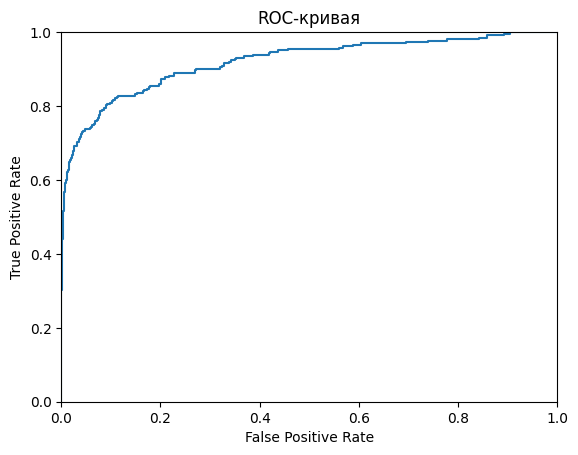

In [ ]:
probabilities_cat = best_model_cat.predict_proba(features_test_ohe)
probabilities_one_cat = probabilities_cat[:,1]
fpr_cat,tpr_cat,thresholds = roc_curve(target_test,probabilities_one_cat)

auc_roc_cat = roc_auc_score(target_test,probabilities_one_cat)

print('AUC-ROC:', auc_roc_cat)

plt.figure()
plt.plot(fpr_cat, tpr_cat)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

AUC-ROC оказался равным 0,91967. Немного лучше чем на обучающей выборке.

#Вывод

Таким образом, мы проанализировали датасет с клиентами компании «Ниединогоразрыва.ком». Для начала мы предобработали наши данные: проверили наличие дубликатов, обработали явные и неявные пропуски, добавили необходимые столбцы. Потом исследовали наш датасет. Определили что популярно и наших клиентов, посмотрели наличие корреляции признаков. На этапе обучения моделей мы проверили 3 модели и выбрали наилучшую. Это оказалась CatBoostClassifier, модель показала наилучший AUC-ROC. После мы посмотрели результат работы на тестовых данных. После проведенного исследования мы с увереностью можем рекомендовать компании модель CatBoostClassifier для прогнозирования оттока клиентов.

#Отчет

Мы проделали большую работу по проекту прогнозирования оттока клиентов. Нам необходимо было создать модель машинного обучения, прогнозирующую отток клиентов с метрикой качества AUC-ROC большей 0.85.

Первый этап это предобработка данных. Сперва мы посмотрели что находится в каждом из 4 файлов, предоставленных нам, и объединили их в один и работали только с ним. Нам необходимо было добавить целевой признак, так как у нас его не было. 0 означает что клиент с нами, 1 - что ушел. Потом мы высчитали как долго человек является нашим клиентом. Обработали явные пропуски в следующих колонках:
1. InternetService,
2. OnlineSecurity,
3. OnlineBackup,
4. DeviceProtection,
5. TechSupport,
6. StreamingTV,
7. StreamingMovies,
8. MultipleLines.

Путем замены пустых строк на 'No'. Так же у нас нашлись неявные пропуски в колонке TotalCharges, а именно удалили эти строки, так как они для нас бесполезны и изменили тип данных в этой колонке на int.

Следующий этап - исследовательский анализ данных. На нем мы визуализировали категориальные признаки, что бы лучше узнать нашего клиента и найти возможные закономерности. Рассмотрели коррелирующие признаки, у нас оказалось две пары, это: MonthlyCharges и TotalCharges, а вторая TotalCharges и duration. Удалили TotalCharges, так как он сразу коррелирует с двумя признаками.Потом мы приступили к обучению моделей. Вывели отдельно целевой признак target и переменные предикторы:
1. Type,
2. PaperlessBilling,
3. PaymentMethod,
4. MonthlyCharges,
5. InternetService,
6. OnlineSecurity,
7. OnlineBackup,
8. DeviceProtection,
9. TechSupport,
10. StreamingTV,
11. StreamingMovies,
12. gender,
13. SeniorCitizen,
14. Partner,
15. Dependents,
16. MultipleLines,
17. duration.

Разбили датасет на обучающую и тестовую выборки. Для тестовой выборки отобрали 25%. Закодировали выборки методом OHE и приступили к обучению. Было выбранно три модели: случайный лес, LGBMClassifier и CatBoostClassifier. Во всех моделях сделали стандартный random_state, равный 80523. Для отбора использовали метод кросс валидации со scoring равным roc_auc и 5 выборками. В итоге лучше всего себя показал CatBoostClassifier со следующими гипрепараметрами:
1. Количество деревьев 1000;
2. Скорость обучения 0.07.

После определения наилучшей модели ее проверили на тестовых данных и в конце был написан небольшой вывод с рекомендациями заказчику.

В целом мы выполнили все по предполагаемому плану и без каких то конеретных трудностей. Сложно выделить какой то ключевой этап в этом исследовании. Каждый этап был важен для получения итогового результата, так как на каждом этапе происходили преобразования данных или подбор модели. Нельзя удалить какой либо из этапов без потери важной информации.